In [1]:
from imageio import imread




from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score

In [2]:

# FrankeFunction, from lecture notes
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 


# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


# Defining the Mean square error, from lecture notes
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)



# Creating the design matrix, from lecture notes
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    return np.linalg.pinv(X.T @ X) @ X.T @ z



#Ridgeregression
def ridgeregg(X,y, lmb = 0.0001):
    XtX = X.T @ X
    p =np.shape(XtX)[0]

    return np.linalg.pinv(XtX +  lmb * np.identity(p)) @ X.T @ y

#Lassoregression using sklern
def lassoregg(X,y,lmb = 0.0001):
    RegLasso = Lasso(lmb,fit_intercept=False,max_iter=10000)
    RegLasso.fit(X,y)
    return RegLasso.coef_
    #pred_y = RegLasso.predict(X)
    
    


def surfaceplot(x,y,z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

    
def printQ(xdata,xmodel):
    print("--------------------------------------------------------")
    print(f"MSE = |{MSE(xdata,xmodel)}|, R2 = |{r2_score(xdata,xmodel)}|")
    print("--------------------------------------------------------\n")
    
# calculating the MSE, bias and variance using the bootstrap method
def BootstrapOLS(X_train,X_test,z_train,z_test,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaOLS = OLSmethod(bootX,bootz)
        # Making out model and adding it to a list
        ztilde = X_test @ bootbetaOLS
        zpred = X_train @ bootbetaOLS
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)


def BootstrapRidge(X_train,X_test,z_train,z_test,lam,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaRidge = ridgeregg(bootX,bootz,lam)
        # Making out model and adding it to a list
        ztilde = X_test @ bootbetaRidge
        zpred = X_train @ bootbetaRidge
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,zpred)
             
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)

def BootstrapLasso(X_train,X_test,z_train,z_test,lam,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaLasso = lassoregg(bootX,bootz,lam)
        #Creating model and adding to list
        ztilde = X_test @ bootbetaLasso
        zpred = X_train @ bootbetaLasso
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)

def plotMSEcomplexity(x,y,z,n):
    MSElisttest = []
    MSElisttrain = []
    biasList =[]
    varianceList =[] 
    n = n+1
    complexity = np.arange(n)
    print(f"The polynomial range is [{complexity[0]},{complexity[-1]}] ")
    
    # Running over the degrees of polynomails
    for degree in complexity:
        # Creating the designmatrix and splitting into train and test
        X = create_X(x,y,degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)
        
        numberOfStraps = 100
        MSE_train, MSE_test,bias,variance = BootstrapOLS(X_train,X_test,z_train,z_test,numberOfStraps)
        
        
        # Appending the mean to the MSE list when the loop has run for its specific degree
        MSElisttest.append(MSE_train)
        MSElisttrain.append(MSE_test)
        biasList.append(bias)
        varianceList.append(variance)
        
    plt.title('ERROR')
    plt.plot(complexity,MSElisttest,"r", label = "test")
    plt.plot(complexity,MSElisttrain,"k", label = "train")
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.ylabel("MSE")
    plt.title("Figure of the MSE as a function of the complexity of the model")
    plt.legend()
    plt.show()
    
    plt.title('Bias variance')
    plt.plot(complexity,biasList,"r", label = "bias",ls='',marker='o')
    plt.plot(complexity,varianceList,"k", label = "variance",ls='',marker='o')
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.ylabel("MSE")
    plt.title("Figure of the MSE as a function of the complexity of the model")
    plt.legend()
    plt.show()
    
    
def confidense(y,X): #finding the confidence intervall for beta
    var = 1 
    XtX = np.linalg.pinv(X.T@X)
    conf = 2*var*np.sqrt(np.diag(XtX))
    return conf

def biassVariance(y,y_pred): 
    mean_pred = np.mean(y_pred)
    bias = np.mean((y - mean_pred)**2)
    variance = np.mean((y_pred - mean_pred)**2)
    return bias, variance


def k_foldOLS(Data, k,X): 
    "Splitting the data"
    k_split = KFold(n_splits = k)
    "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(k_train_index)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_OLS = OLSmethod(k_xtrain, k_ytrain)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_OLS

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
  #  print(k_scores)
    MSE_kfold = np.mean(k_scores)
   # print('MSE for k-fold OLS')
   # print(MSE_kfold)
    return MSE_kfold

def k_foldRigd(Data, k,X): 
    "Splitting the data"
    k_split = KFold(n_splits = k)
    "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(k_train_index)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_OLS = OLSmethod(k_xtrain, k_ytrain)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_OLS

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
  #  print(k_scores)
    MSE_kfold = np.mean(k_scores)
   # print('MSE for k-fold OLS')
   # print(MSE_kfold)
    return MSE_kfold


In [3]:
# Load the terrain
data = imread("SRTM_data_Norway_1.tif")
# Show the terrain
#print(type(data))
#data = np.array(terrain1)
#print(data.shape)
#print(data)
"""plt.figure()
plt.title("Terrain over Norway 1")
plt.imshow(data, cmap="gray")
plt.xlabel("’X’")
plt.colorbar()
plt.ylabel("’Y’")
plt.show()"""
for i in range(8):
        #print(data.shape)
        data = np.delete(data, slice(None, None, 3), axis=0)
        data = np.delete(data, slice(None, None, 3), axis=1)
        



In [4]:



n,m = data.shape
#print(n,m)



# Make data.
x = np.linspace(0, 1801, m)
y = np.linspace(0, 3601, n)



npoly1 = np.arange(0,13) #Set this to 30 and you get a result worth using

x,y = np.meshgrid(x,y)


z = data
R2test = []
R2train = []

# For the ordinary not bootstraped
MSEtest = []
MSEtrain = []

# For the bootstrap
Boot_MSE_test = []
Boot_MSE_train = []
for npoly in npoly1:
    #print(f"---{npoly}---")
    X = create_X(x,y,npoly)


    X_train, X_test, z_train, z_test = train_test_split(X,z.reshape(-1,1), test_size = 0.2)

    #Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    z_train_scaled = scaler.fit_transform(z_train)
    z_test_scaled = scaler.fit_transform(z_test)
    
    MSEtest1, MSEtrain1, boot, variance = BootstrapOLS(X_train_scaled,X_test_scaled,z_train_scaled,z_test_scaled,30)
    Boot_MSE_train.append(MSEtrain1)
    Boot_MSE_test.append(MSEtest1)
    
    X_scaled = scaler.fit_transform(X)
    z_scaled = scaler.fit_transform(z)


    beta = OLSmethod(X_train_scaled,z_train_scaled)

    # Making the fit for the 
    ztilde = X_train_scaled @ beta

    
    zpred = X_test_scaled @ beta

    
    MSEtest.append(MSE(z_test_scaled,zpred))
    MSEtrain.append(MSE(z_train_scaled,ztilde))
    
    R2test.append(R2(z_test_scaled,zpred))
    R2train.append(R2(z_train_scaled,ztilde))


    
    


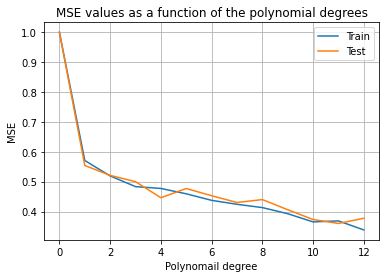

In [5]:
"""#Ordinart
plt.plot(npoly1,R2test, label =" R2")
plt.plot(npoly1,MSEtest,label = "MSE")
plt.legend()
plt.grid()
plt.xlabel("Polynomial degree")
plt.title("MSE and R2 for the test data as a function of polynomial degree")
plt.ylabel("Value")
plt.show()

plt.plot(npoly1,R2train, label =" R2")
plt.plot(npoly1,MSEtrain,label = "MSE")

plt.legend()
plt.grid()
plt.xlabel("Polynomial degree")
plt.title("MSE and R2 for the training data as a function of polynomial degree")
plt.ylabel("Value")
"""
#Bootstrap
plt.ylabel("MSE")
plt.grid()
plt.xlabel("Polynomail degree")
plt.plot(npoly1,Boot_MSE_train,label = "Train")
plt.plot(npoly1,Boot_MSE_test,label = "Test")
plt.title("MSE values as a function of the polynomial degrees")
plt.legend()



In [8]:
lam = np.logspace(-2,3,6)

bdeg = 16
#for Ridge


#for Lasso

TestMSElist = []
TrainMSElist = []
biaslist = []
variancelist = []

for alpha in lam:
    X = create_X(x,y,bdeg)
    X_train, X_test, z_train, z_test = train_test_split(X,z.reshape(-1,1), test_size = 0.2)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    z_train_scaled = scaler.fit_transform(z_train)
    z_test_scaled = scaler.fit_transform(z_test)
    
    
    TestMSE, TrainMSE, bias, variance= BootstrapRidge(X_train_scaled,X_test_scaled,z_train_scaled,z_test_scaled,alpha,30)
    TestMSElist.append(TestMSE)
    TrainMSElist.append(TrainMSE)
    biaslist.append(bias)
    variancelist.append(variance)
        

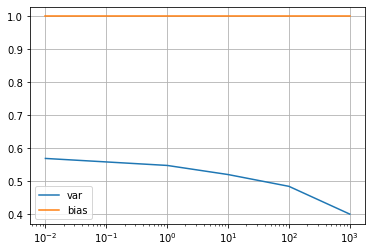

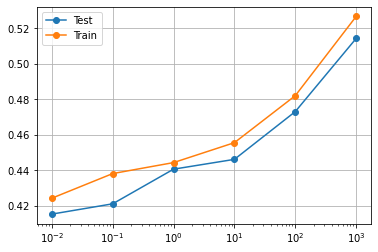

In [16]:
plt.semilogx(lam,variancelist,label='var')
plt.semilogx(lam,biaslist,label = "bias")
plt.grid()
plt.legend()
plt.show()

plt.semilogx(lam,TestMSElist, "-o" ,label = "Test")
plt.semilogx(lam,TrainMSElist, "-o",label = "Train")
plt.grid()
plt.legend()